In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import subprocess
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from scipy.io import loadmat
import natsort, pathlib
import os
import glob

In [2]:
colormap_data = loadmat('cold2hot.mat')
cold2hot = ListedColormap(colormap_data['colormap'])
hot2cold = ListedColormap(colormap_data['colormap'][::-1])

In [3]:
# path = os.path.abspath('../0_MOOSE_Input_Files/Heat_Sources/')
path = os.path.abspath('/home/enlightenment/members_directory/upadesh_subedi/Phase Field/Laser_processing/Au-Au/HS_ML/')

## TDB for Label (Meltpool)

In [4]:
TDB_BHS = path+'/Bessel/TDB/exodus/Au-Au.e'
TDB_GHS = path+'/Gaussian/TDB/exodus/Au-Au.e'
TDB_FTHS = path+'/FlatTop/TDB/exodus/Au-Au.e'
TDB_RHS = path+'/Ring/TDB/exodus/Au-Au.e'

FIT_BHS = path+'/Bessel/Fitting/exodus/Au-Au.e'
FIT_GHS = path+'/Gaussian/Fitting/exodus/Au-Au.e'
FIT_FTHS = path+'/FlatTop/Fitting/exodus/Au-Au.e'
FIT_RHS = path+'/Ring/Fitting/exodus/Au-Au.e'

In [39]:
model_TDB = netCDF4.Dataset(TDB_BHS)
model_FIT = netCDF4.Dataset(FIT_BHS)

In [40]:
names = model_TDB.variables["name_nod_var"]
names.set_auto_mask(False)
param_in_exodus = [b"".join(c).decode("latin1") for c in names[:]]
print(param_in_exodus)

['eta1', 'p', 'temp', 'vel_x', 'vel_y']


In [41]:
parameters = ['vals_nod_var1', 'vals_nod_var3',]

In [42]:
def Exodus_Extractor(model) -> netCDF4._netCDF4.Dataset :
    LIQ, temp = [], []
    for i in range(2):
        param = model.variables[parameters[i]][:]
    
        X_all = model.variables['coordx'][:]
        Y_all = model.variables['coordy'][:]
        
        points = np.vstack([Y_all,X_all,param]).T
        
        column_names = ['X', 'Y'] + list(range(param.shape[0]))
        df = pd.DataFrame(points, columns=column_names)
        df = df.sort_values(by = ['X', 'Y'], ascending = [True, True], ignore_index=True)
        df_param = df.iloc[:, 2:]
        
        x_dim  = model.dimensions['num_nod_ns1'].size
        y_dim =  model.dimensions['num_nod_ns2'].size
        time_steps = model.dimensions['time_step'].size
        array_ = df_param.to_numpy().flatten().reshape(y_dim, x_dim, time_steps)
        array = np.flip(array_, axis=0)
        if i == 0:
            LIQ.append(array)
        else:
            temp.append(array)

    return LIQ[0], temp[0]

In [43]:
LIQ_TDB, temp_TDB = Exodus_Extractor(model_TDB)

In [44]:
LIQ_FIT, temp_FIT = Exodus_Extractor(model_FIT)

In [45]:
time_TDB = np.array(model_TDB.variables['time_whole'][:]).reshape((-1, ))
time_FIT = np.array(model_FIT.variables['time_whole'][:]).reshape((-1, ))

t_a = [np.argmin(np.abs(time_TDB - 0.9)), time_TDB.shape[0], np.argmin(np.abs(time_FIT - 0.9)), time_FIT.shape[0]]
t_a, t_a[1]-t_a[0], t_a[3]-t_a[2]

([58, 863, 132, 937], 805, 805)

In [46]:
# Gaussian ([54, 859, 140, 945], 805, 805)
# FlatTop  ([69, 874, 140, 945], 805, 805)

time_TDB = np.array(model_TDB.variables['time_whole'][:]).reshape((-1, ))[np.r_[t_a[0]:t_a[1]]]
time_FIT = np.array(model_FIT.variables['time_whole'][:]).reshape((-1, ))[np.r_[t_a[2]:t_a[3]]]

LIQ = np.where(LIQ_TDB < 0.5, 0, 1)[:, :, np.r_[t_a[0]:t_a[1]]]
temp = temp_FIT[:, :, np.r_[t_a[2]:t_a[3]]]

X_, y_ = np.moveaxis(temp, -1, 0), np.moveaxis(LIQ, -1, 0)

differences = np.round(np.round(time_FIT, 10)-np.round(time_TDB, 10), 10)
np.all(differences[:-1] == differences[0]), sum(time_FIT-time_TDB)

# temperature = np.where(temp < 1337, 0, 1)
# X_, y_ = np.moveaxis(temperature, -1, 0), np.moveaxis(LIQ, -1, 0)

(True, 0.0)

In [47]:
differences = np.round(np.round(time_FIT, 10)-np.round(time_TDB, 10), 10)
np.all(differences[:-1] == differences[0])

True

In [14]:
X, y = X_, y_ # Run this only for the first time

In [15]:
y.shape

(805, 201, 401)

In [48]:
X, y = np.concatenate((X, X_), axis=0), np.concatenate((y, y_), axis=0)
X.shape, y.shape

((3220, 201, 401), (3220, 201, 401))

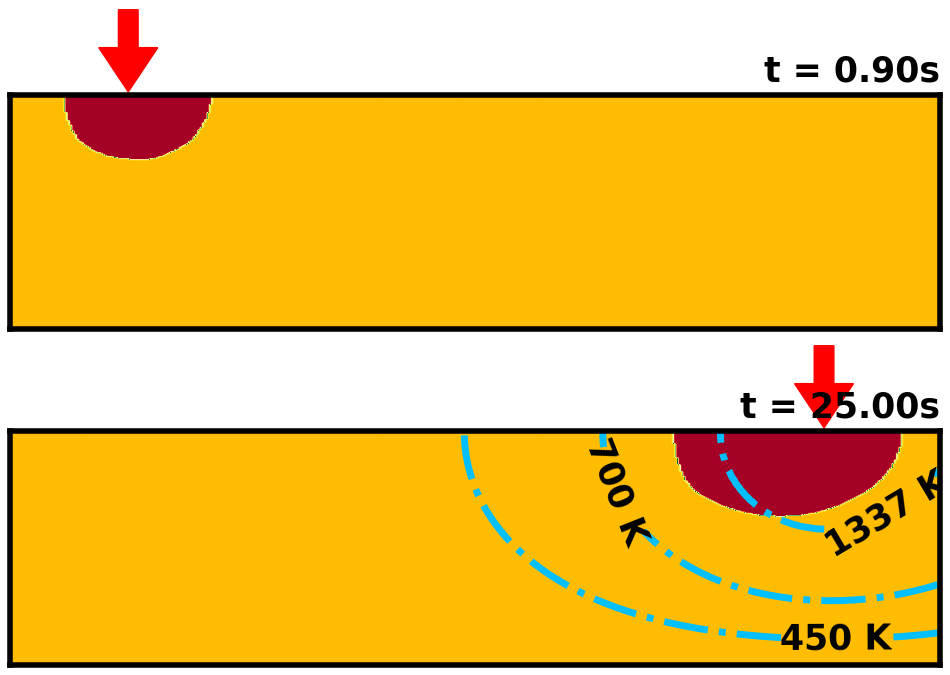

In [49]:
t_step = -1
laser_speed = 30
laser_pos = (125 + time_TDB[t_step]*laser_speed)* 401/1000  # Laser actual position in true dimension

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), frameon=True)
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(y_[0], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='quadric')
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
hmap2 = ax1.imshow(1-y_[0], cmap=cmap, vmin=0.5, vmax=1.5, aspect=0.5, interpolation='quadric')
ax1.arrow(50.125,-75, 0, 71,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax1.set_title(f't = {time_TDB[0]:.2f}s', pad=10, loc='right', fontsize=25, weight='bold')

cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap3 = ax2.imshow(y_[t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='quadric')
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
hmap4 = ax2.imshow(1-y_[t_step], cmap=cmap, vmin=0.5, vmax=1.5, aspect=0.5, interpolation='quadric')
ax2.arrow(laser_pos,-75, 0, 71,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax2.set_title(f't = {time_TDB[t_step]:.2f}s', pad=10, loc='right', fontsize=25, weight='bold')

for ax in [ax1, ax2]: ax.set_ylim(201, -1); ax.set_xlim(-1, 401); ax.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False); ax.spines[:].set_linewidth(4)
for label in ax2.clabel(ax2.contour(X_[t_step], levels=[450, 700, 1337], colors='deepskyblue', linewidths=5, linestyles='dashdot'), inline=True, fontsize=25, colors='k', fmt='%1.0f K'): label.set_fontweight('bold')

In [50]:
##########################################
# Saving as Numpy Files
np.save('data/X.npy', X)
np.save('data/y.npy', y)

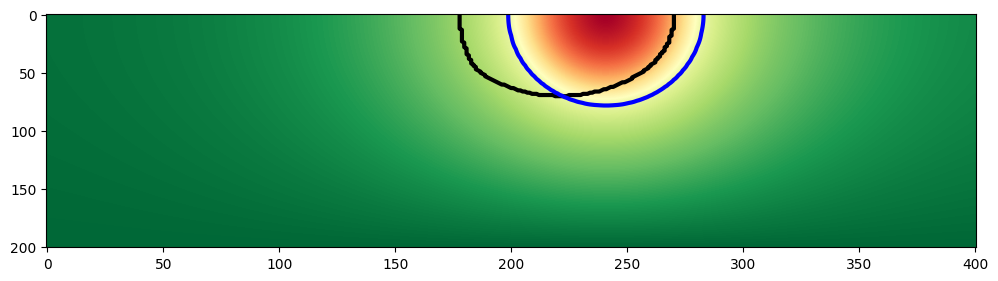

In [80]:
t_step = 500
laser_speed = 30
laser_pos = (125 + time_TDB[t_step]*laser_speed)* 401/1000  # Laser actual position in true dimension

fig, ax1 = plt.subplots(1,1, figsize=(12,4), frameon=True)
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(X_[t_step], cmap=cmap, vmin=300, aspect=0.5,  interpolation='quadric')
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
ax1.contour(y_[t_step], levels=[0.8], colors='k', linewidths=3, linestyles='-')
ax1.contour(X_[t_step], levels=[1337], colors='blue', linewidths=3, linestyles='-')

plt.show()

# Splitting Train Test Validation Dataset

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [6]:
path = os.path.abspath('data/')
X, y = np.load(path+'/X.npy'), np.load(path+'/y.npy')

In [7]:
## Train Validation Test Split
# Reshape X and y to match PyTorch's Conv2d input format: (batch_size, channels, width, height)
X_reshaped = X[:, np.newaxis, :, :] 
y_reshaped = y[:, np.newaxis, :, :] 

# Split data into training, testing, validation sets
X_, X_test, y_, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.1, random_state=93)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.111, random_state=93)  #test_size=0.109


In [10]:
np.save('data/X_test.npy', X_test)
np.save('data/y_test.npy', y_test)